# Variational Auto-Encoder

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from util import suppress_tf_warning,get_vars,gpu_sess
suppress_tf_warning()
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
print ("TF version: %s"%(tf.__version__))

TF version: 1.15.0


### Define VAE

In [2]:
class VariationalAutoEncoderClass(object):
    """
    Variational AutoEncoder
    """
    def __init__(self,name='VAE',x_dim=784,z_dim=16,
                 h_dims_Q=[256]*2,h_dims_P=[256]*2,actv_Q=tf.nn.relu,actv_P=tf.nn.relu,
                 std_max=np.inf,beta=1.0):
        """
        Initialize
        """
        self.name = name
        self.x_dim = x_dim
        self.z_dim = z_dim
        self.h_dims_Q = h_dims_Q
        self.h_dims_P = h_dims_P
        self.actv_Q = actv_Q
        self.actv_P = actv_P
        self.std_max = std_max
        self.beta = beta
        
        self.build_model()
        self.build_graph()
        
    def build_model(self):
        """
        Build model
        """
        ki = tf.random_normal_initializer(mean=0.0,stddev=0.1)
        bi = tf.constant_initializer(value=0.0)
        self.ph_x_real = tf.placeholder(dtype=tf.float32,shape=[None,self.x_dim],name='x_real')
        self.ph_x_trgt = tf.placeholder(dtype=tf.float32,shape=[None,self.x_dim],name='x_trgt')
        self.ph_z_real = tf.placeholder(dtype=tf.float32,shape=[None,self.z_dim],name='z_real')
        self.lr = tf.placeholder(dtype=tf.float32,shape=[],name='lr')
        self.ph_is_training = tf.placeholder(dtype=tf.bool,shape=[],name='is_training')
        self.n = tf.shape(self.ph_x_real)[0] # number of x_real
        
        with tf.variable_scope(self.name):
            # Encoder Q: ph_x_real -> z_sample
            with tf.variable_scope('Q',reuse=False):
                net = self.ph_x_real
                for h_idx,h_dim in enumerate(self.h_dims_Q):
                    net = tf.layers.dense(net,h_dim,activation=self.actv_Q,
                                          kernel_initializer=ki,bias_initializer=bi,
                                          name='h_Q_lin_%d'%(h_idx))
                self.z_mu = tf.layers.dense(net,self.z_dim,activation=None,
                                            kernel_initializer=ki,bias_initializer=bi,
                                            name='z_mu') # [N x z_dim]
                self.z_log_std = tf.layers.dense(net,self.z_dim,activation=None,
                                                 kernel_initializer=ki,bias_initializer=bi,
                                                 name='z_log_var') # [N x z_dim]
                if self.std_max == np.inf:
                    self.z_std = tf.exp(self.z_log_std)
                else:
                    self.z_std = self.var_max * tf.sigmoid(self.z_log_std)
                    
                # Z sample
                self.eps = tf.random.normal(shape=(self.n,self.z_dim),mean=0.0,stddev=1.0,dtype=tf.float32)
                self.z_sample = self.z_mu + self.z_std*self.eps # [N x z_dim]

            # Decoder P: z_sample -> x_recon
            with tf.variable_scope('P',reuse=False):
                net = self.z_sample
                for h_idx,h_dim in enumerate(self.h_dims_P):
                    net = tf.layers.dense(net,h_dim,activation=self.actv_P,
                                          kernel_initializer=ki,bias_initializer=bi,
                                          name='h_P_lin_%d'%(h_idx))
                net = tf.layers.dropout(net,rate=0.5,training=self.ph_is_training)
                # Recon
                self.x_recon = tf.layers.dense(net,self.x_dim,activation=self.actv_P,
                                               kernel_initializer=ki,bias_initializer=bi,
                                               name='x_recon') # [N x x_dim]

            # (Reuse) Decoder P: ph_z_real -> x_decode 
            with tf.variable_scope('P',reuse=True):
                net = self.ph_z_real
                for h_idx,h_dim in enumerate(self.h_dims_P):
                    net = tf.layers.dense(net,h_dim,activation=self.actv_P,
                                          kernel_initializer=ki,bias_initializer=bi,
                                          name='h_P_lin_%d'%(h_idx))
                # Dropout <= this helps alleviating some dead artifacts 
                net = tf.layers.dropout(net,rate=0.5,training=self.ph_is_training)
                # Recon
                self.x_decode = tf.layers.dense(net,self.x_dim,activation=self.actv_P,
                                               kernel_initializer=ki,bias_initializer=bi,
                                               name='x_recon') # [N x x_dim]
                
        # Get variables
        self.vae_vars = get_vars(self.name)
        self.p_vars = get_vars(self.name+'/P')
        self.q_vars = get_vars(self.name+'/Q')
    
    def build_graph(self):
        """
        Build graph
        """
        # Losses
        self.l1_losses = tf.reduce_sum(tf.abs(self.x_recon-self.ph_x_trgt),axis=1) # [n] 
        self.l2_losses = tf.reduce_sum((self.x_recon-self.ph_x_trgt)**2,axis=1) # [n] 
        self.recon_losses = self.l2_losses # [n]
        self.recon_loss = tf.reduce_mean(self.recon_losses) # [1]
        
        EPS = 1e-8
        self.kl_losses = 0.5*( self.z_std**2 + self.z_mu**2 - tf.log(self.z_std**2+EPS) - 1.0 ) 
        self.kl_losses = tf.reduce_sum(self.kl_losses,axis=1) # [n]
        self.kl_loss = self.beta*tf.reduce_mean(self.kl_losses) # [1]
        
        # Optimizer
        self.optm = tf.train.AdamOptimizer(self.lr).minimize(
            self.recon_loss+self.kl_loss,var_list=self.vae_vars)
        
    def update(self,sess,x_batch,lr=1e-3):
        """
        Update
        """
        feeds = {self.ph_x_real:x_batch,self.ph_x_trgt:x_batch,self.lr:lr,
                 self.ph_is_training:True}
        _,recon_loss,kl_loss = sess.run(
            [self.optm,self.recon_loss,self.kl_loss],feed_dict=feeds
            )
        return recon_loss,kl_loss
        
print ("Ready.")

Ready.


### Training data

In [3]:
(x_train,y_train), (x_test,y_test) = mnist.load_data() 
x,y = x_train.reshape(60000,784)/255.0,y_train
n,x_dim = x.shape[0],x.shape[1]
print ("n:[%d] x_dim:[%d]."%(n,x_dim))

n:[60000] x_dim:[784].


### Instantiate VAE

In [4]:
tf.reset_default_graph()
sess = gpu_sess()
V = VariationalAutoEncoderClass(
    name='vae',x_dim=x_dim,z_dim=2,h_dims_Q=[256]*2,h_dims_P=[256]*2,
    actv_Q=tf.nn.relu,actv_P=tf.nn.relu,std_max=np.inf,beta=1.0)
print ("[%s] instantiated."%(V.name))

[vae] instantiated.


### Plot helper functions

In [5]:
def plot_z_sample_and_mu(V,sess,x,figsize=(8,3)):
    feeds = {V.ph_x_real:x,V.ph_is_training:False}
    z_sample,z_mu,x_recon = sess.run([V.z_sample,V.z_mu,V.x_recon],feed_dict=feeds)
    # Plot z sample and z mu 
    plt.figure(figsize=figsize)
    plt.subplot(1,2,1)
    plt.scatter(z_sample[:,0],z_sample[:,1],c=y,cmap='jet')
    plt.title('Z Sample',fontsize=15);plt.colorbar();plt.grid()
    plt.xlim([-4,4]); plt.ylim([-4,4]);
    plt.subplot(1,2,2)
    plt.scatter(z_mu[:,0],z_mu[:,1],c=y,cmap='jet')
    plt.title('Z mu',fontsize=15);plt.colorbar();plt.grid()
    plt.xlim([-4,4]); plt.ylim([-4,4]);

def plot_input_and_reconstruction(V,sess,x,figsize=(8,2)):
    feeds = {V.ph_x_real:x,V.ph_is_training:False}
    z_sample,z_mu,x_recon = sess.run([V.z_sample,V.z_mu,V.x_recon],feed_dict=feeds)
    n_sample = 5
    randperm_idxs = np.random.permutation(n)[:n_sample]
    fig = plt.figure(figsize=figsize)
    for i in range(n_sample):
        plt.subplot(1,n_sample,i+1)
        plt.imshow(x[randperm_idxs[i],:].reshape(28,28),vmin=0,vmax=1,cmap="gray")
    fig.suptitle("Training Inputs",fontsize=15);plt.show()
    fig = plt.figure(figsize=figsize)
    for i in range(n_sample):
        plt.subplot(1,n_sample,i+1)
        plt.imshow(x_recon[randperm_idxs[i],:].reshape(28,28),vmin=0,vmax=1,cmap="gray")
    fig.suptitle("Reconstructed Inputs",fontsize=15);plt.show()
    
def plot_generated_input(V,sess,x,figsize=(8,2)):
    n_sample = 5
    feeds = {V.ph_x_real:x,V.ph_is_training:False}
    z_sample,z_mu,x_recon = sess.run([V.z_sample,V.z_mu,V.x_recon],feed_dict=feeds)
    z = np.random.randn(n_sample,V.z_dim)
    feed_dict = {V.ph_z_real:z,V.ph_is_training:False}
    x_gen = sess.run(V.x_decode,feed_dict=feed_dict)
    fig = plt.figure(figsize=figsize)
    for i in range(n_sample):
        plt.subplot(1,n_sample,i+1)
        plt.imshow(x_gen[i,:].reshape(28,28),vmin=0,vmax=1,cmap="gray")
    fig.suptitle("Generated Inputs",fontsize=15);plt.show()

def plot_latent_space(V,sess,x,figsize=(6,8)):
    nx = ny = 20
    x_values,y_values = np.linspace(-3,3,nx),np.linspace(-3,3,ny)
    canvas = np.empty((28*ny, 28*nx))
    for i, yi in enumerate(x_values):
        for j, xi in enumerate(y_values):
            feeds = {V.ph_z_real:np.array([[xi, yi]]),V.ph_is_training:False}
            x_gen = sess.run(V.x_decode,feed_dict=feeds)
            canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_gen[0].reshape(28, 28)
    plt.figure(figsize=figsize)        
    Xi, Yi = np.meshgrid(x_values, y_values)
    plt.imshow(canvas, origin="upper", cmap="gray")
    plt.title("Latent Space",fontsize=15);plt.tight_layout();plt.show()
    
print ("Ready.")

Ready.


### Loop

[0/50] recon:[0.385] kl:[0.023].


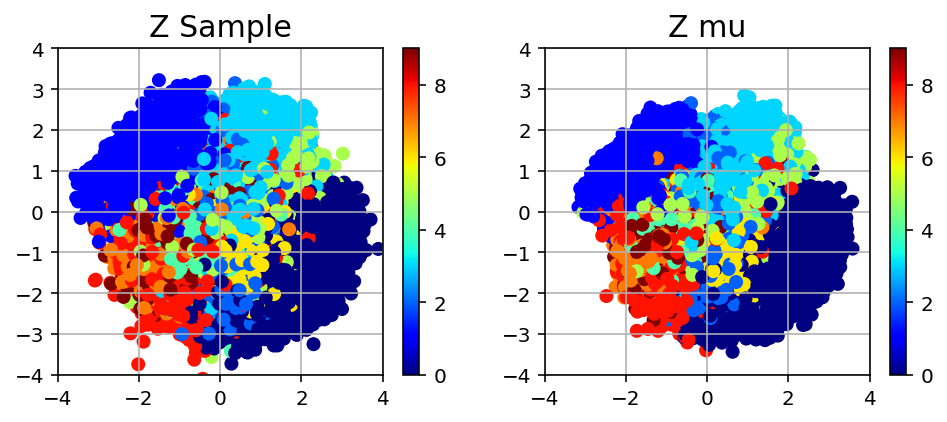

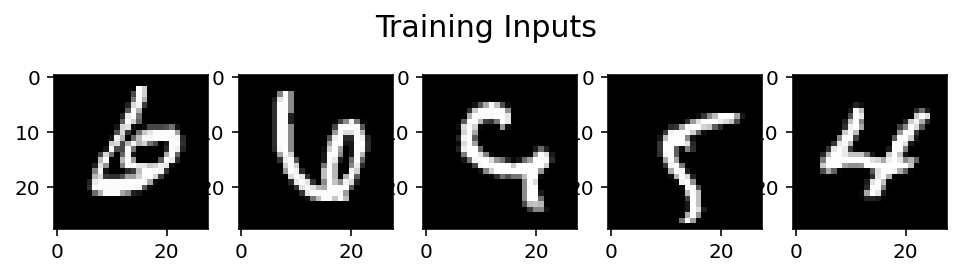

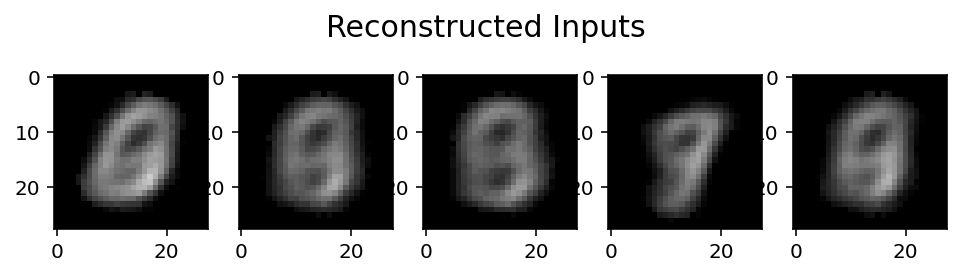

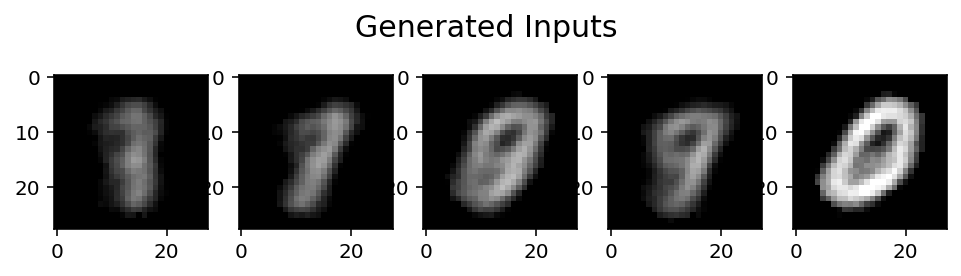

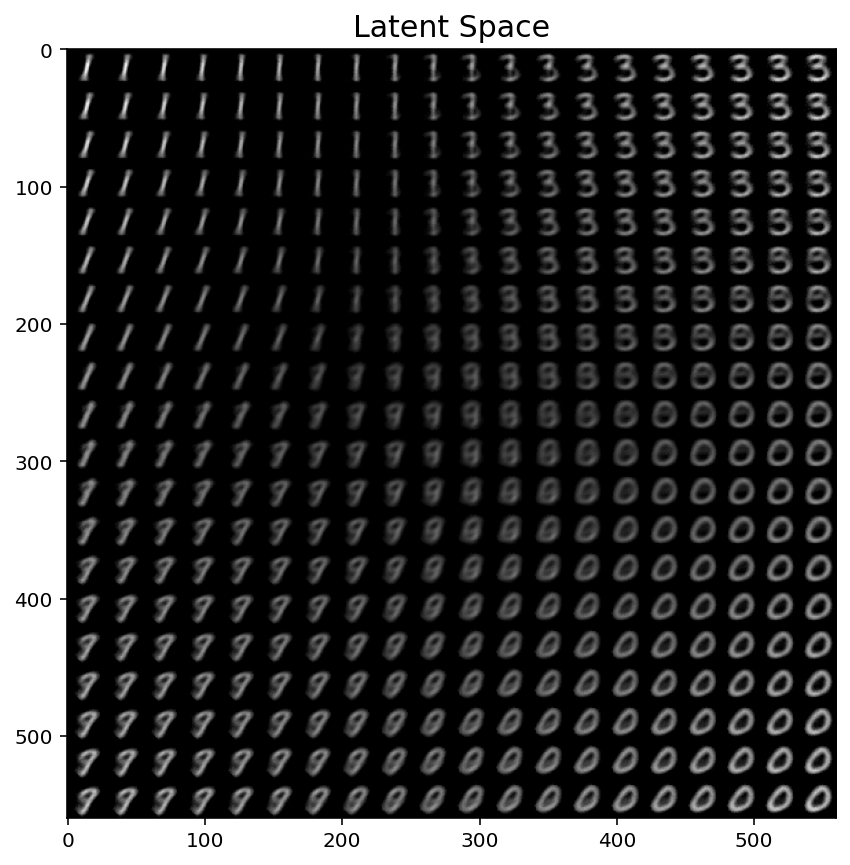

[1/50] recon:[0.326] kl:[0.024].
[2/50] recon:[0.310] kl:[0.026].
[3/50] recon:[0.300] kl:[0.028].
[4/50] recon:[0.294] kl:[0.030].
[5/50] recon:[0.289] kl:[0.031].
[6/50] recon:[0.285] kl:[0.032].
[7/50] recon:[0.281] kl:[0.032].
[8/50] recon:[0.278] kl:[0.033].
[9/50] recon:[0.275] kl:[0.034].
[10/50] recon:[0.272] kl:[0.034].


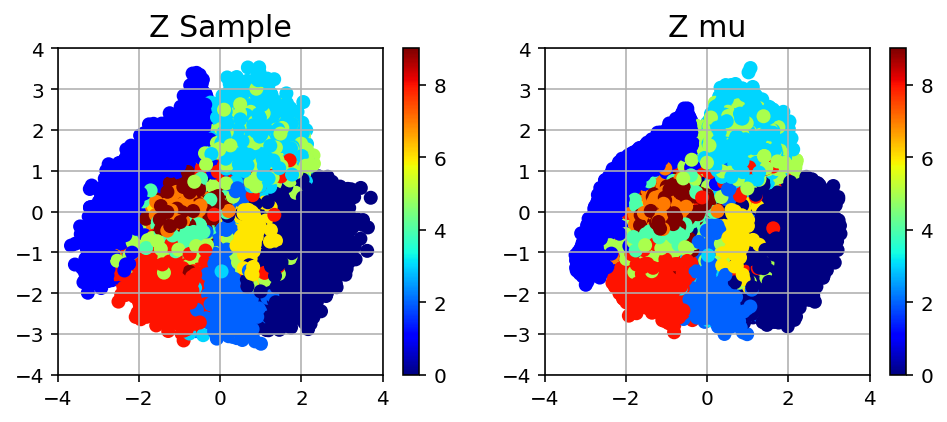

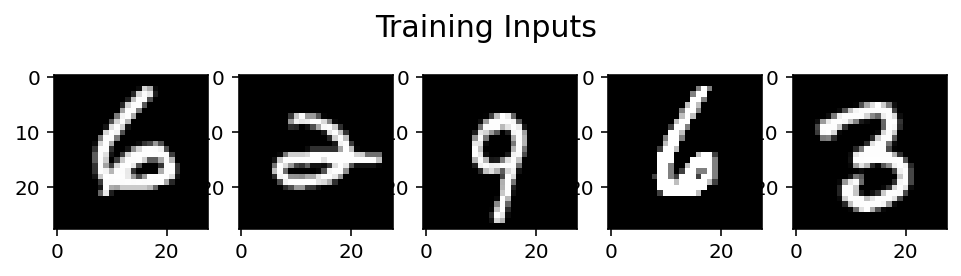

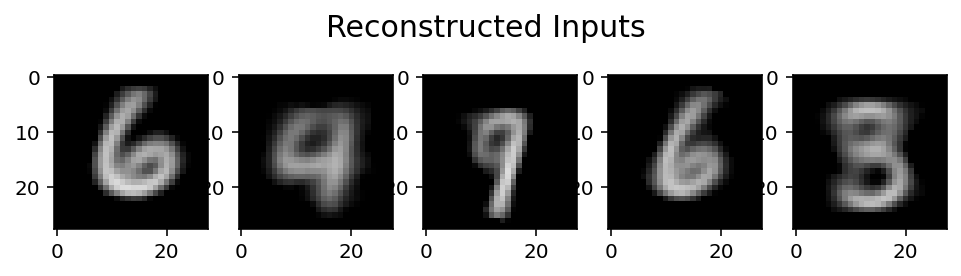

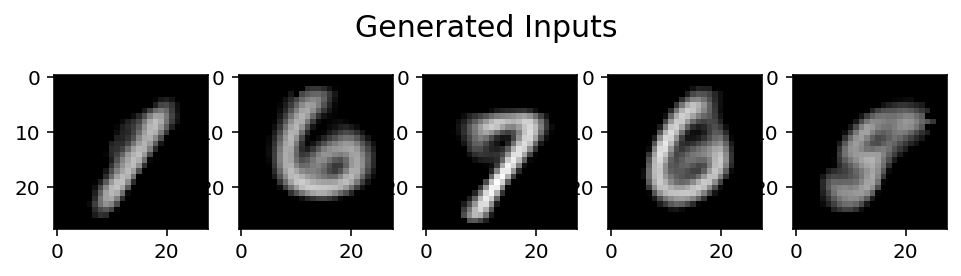

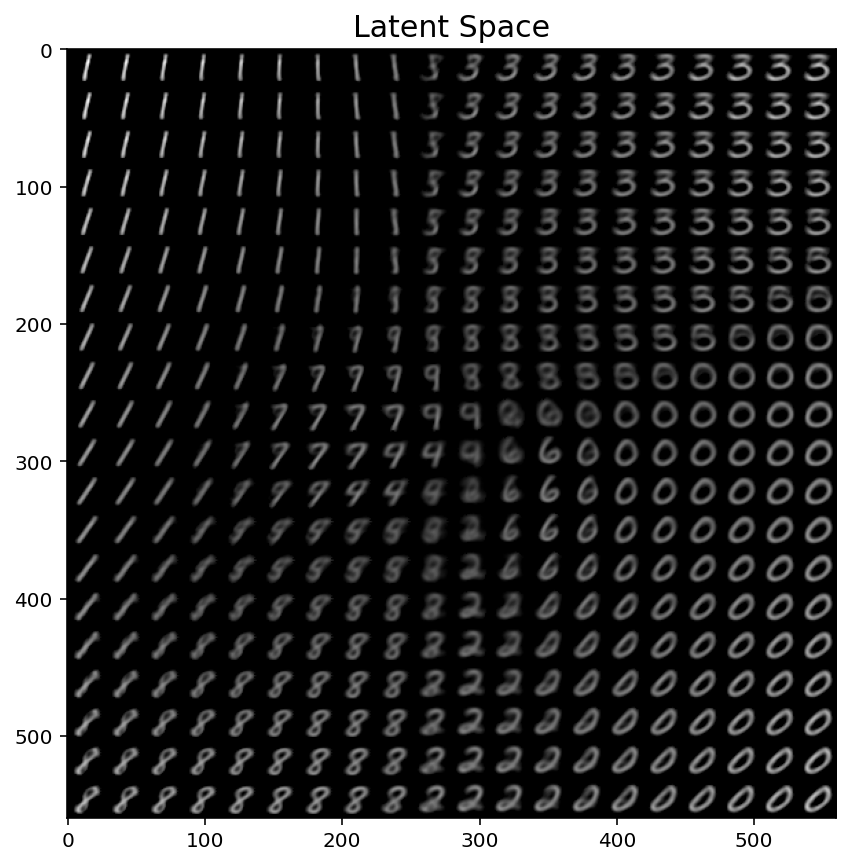

[11/50] recon:[0.271] kl:[0.035].
[12/50] recon:[0.269] kl:[0.035].
[13/50] recon:[0.268] kl:[0.035].
[14/50] recon:[0.266] kl:[0.035].
[15/50] recon:[0.266] kl:[0.036].
[16/50] recon:[0.264] kl:[0.036].
[17/50] recon:[0.264] kl:[0.036].
[18/50] recon:[0.263] kl:[0.036].
[19/50] recon:[0.261] kl:[0.036].
[20/50] recon:[0.261] kl:[0.037].


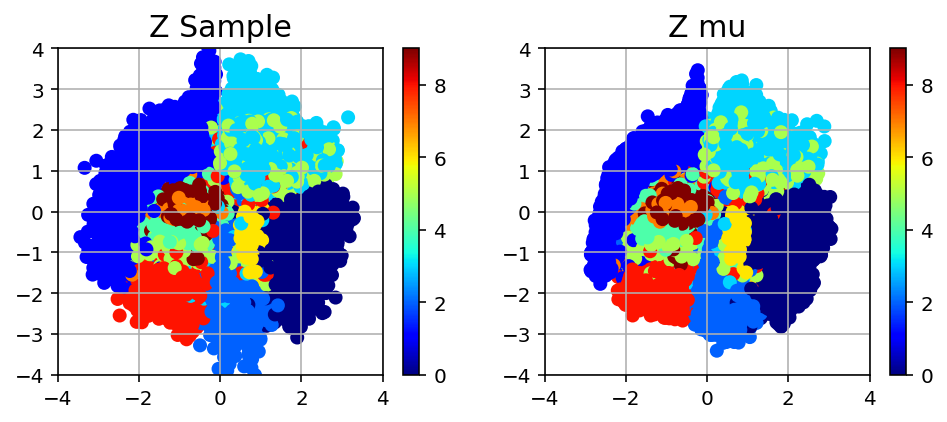

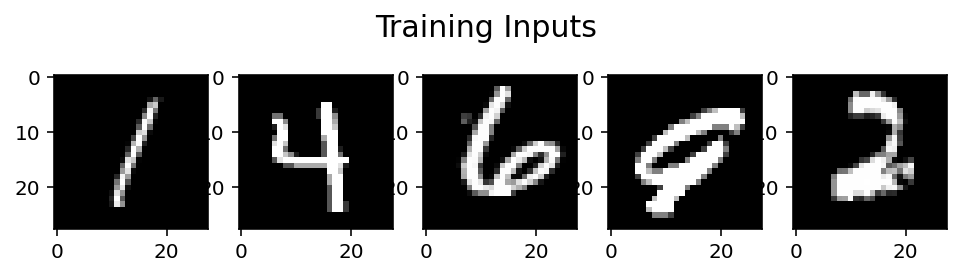

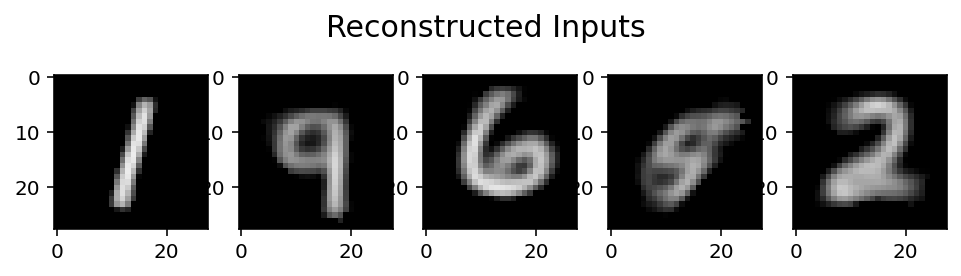

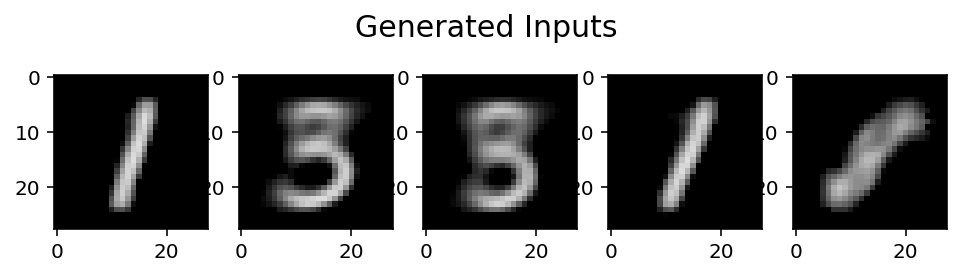

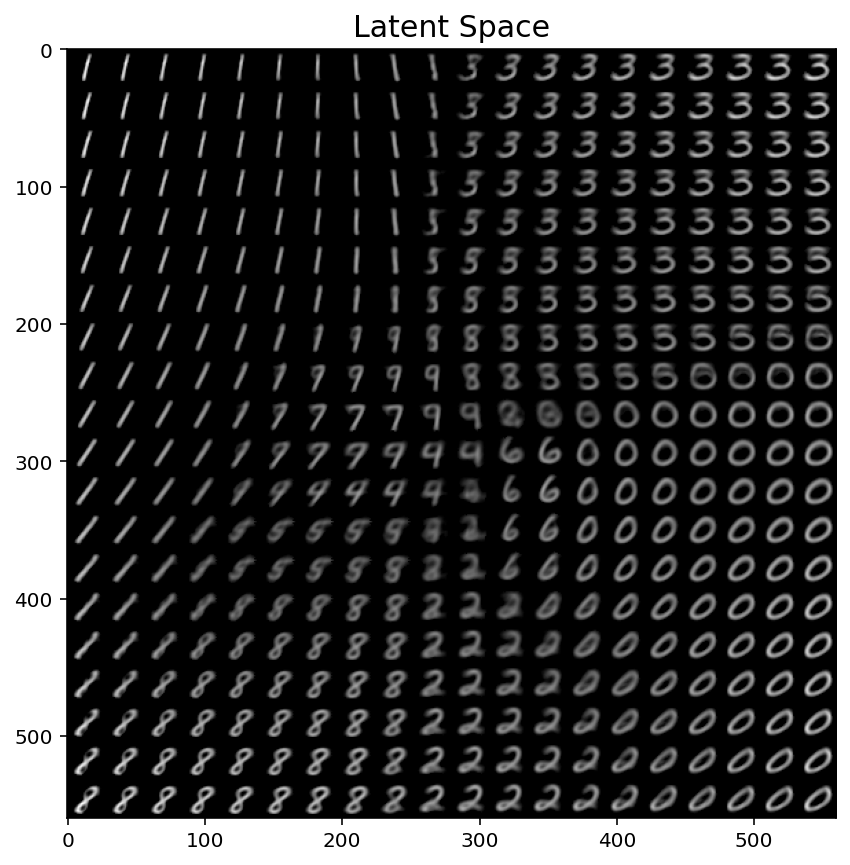

[21/50] recon:[0.261] kl:[0.037].
[22/50] recon:[0.260] kl:[0.037].
[23/50] recon:[0.259] kl:[0.037].
[24/50] recon:[0.258] kl:[0.037].
[25/50] recon:[0.258] kl:[0.037].
[26/50] recon:[0.258] kl:[0.037].
[27/50] recon:[0.257] kl:[0.037].
[28/50] recon:[0.257] kl:[0.038].
[29/50] recon:[0.257] kl:[0.038].
[30/50] recon:[0.256] kl:[0.038].


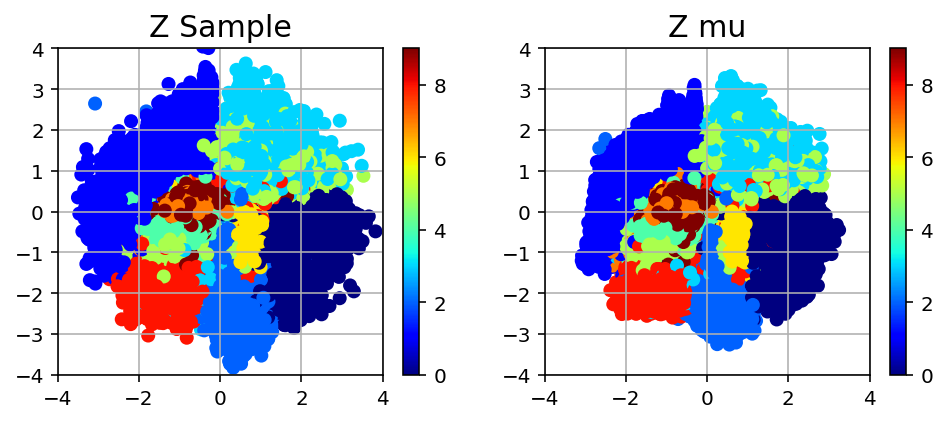

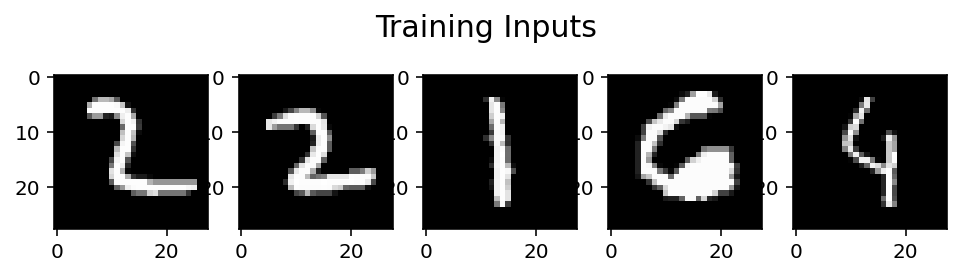

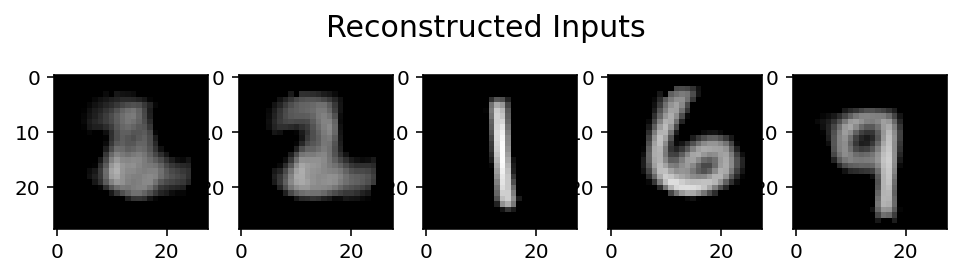

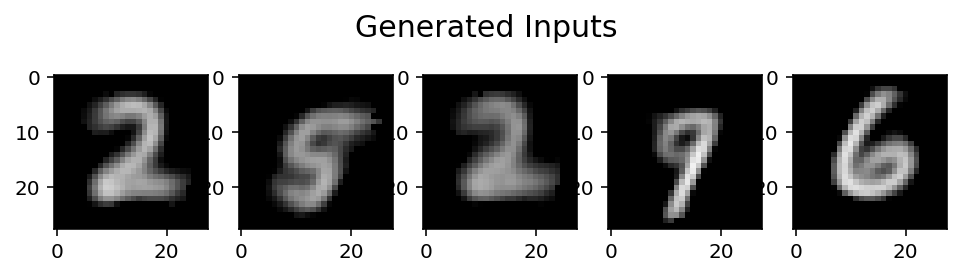

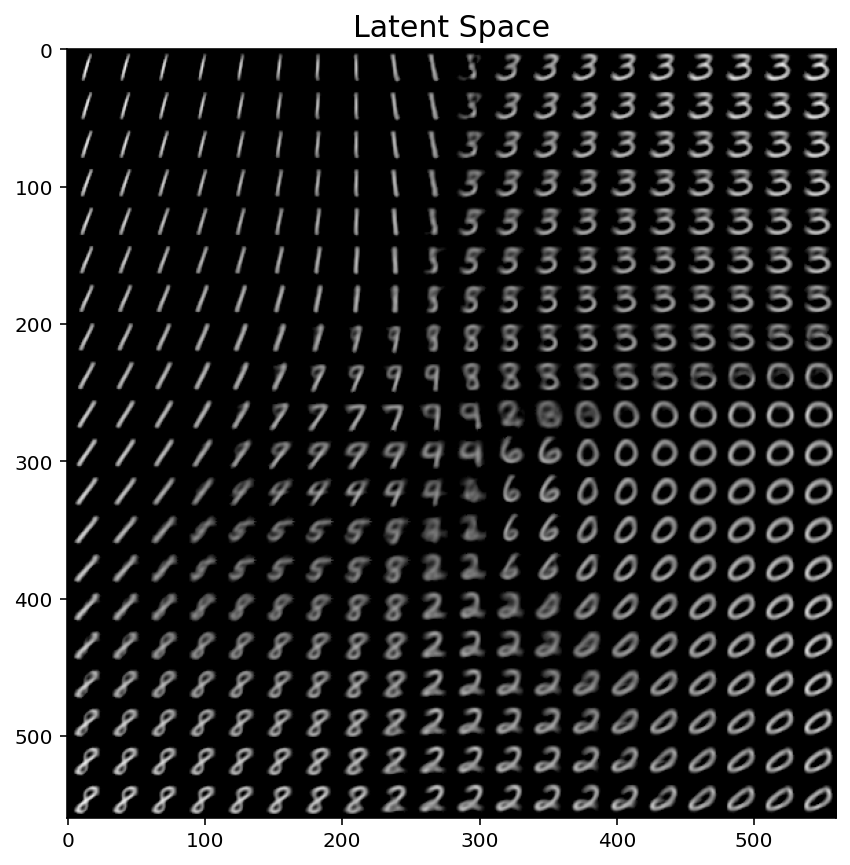

[31/50] recon:[0.256] kl:[0.038].
[32/50] recon:[0.256] kl:[0.038].
[33/50] recon:[0.256] kl:[0.038].
[34/50] recon:[0.255] kl:[0.038].
[35/50] recon:[0.255] kl:[0.038].
[36/50] recon:[0.253] kl:[0.038].
[37/50] recon:[0.254] kl:[0.038].
[38/50] recon:[0.254] kl:[0.038].
[39/50] recon:[0.254] kl:[0.038].
[40/50] recon:[0.253] kl:[0.038].


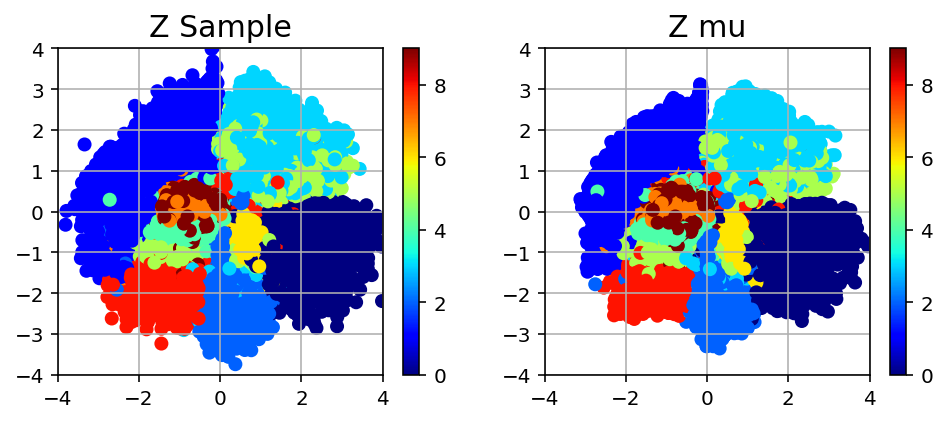

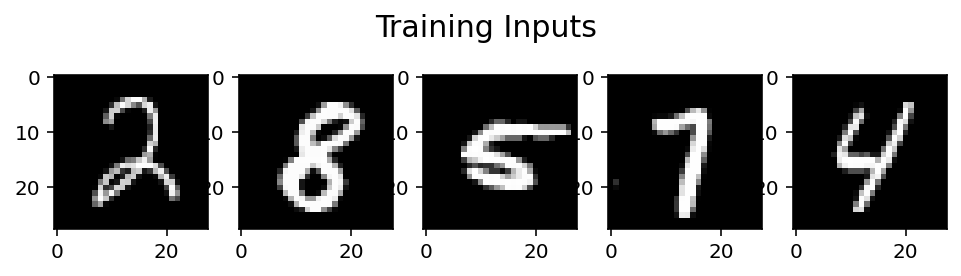

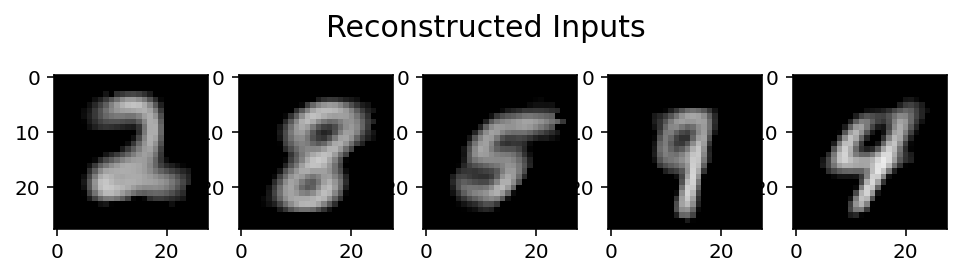

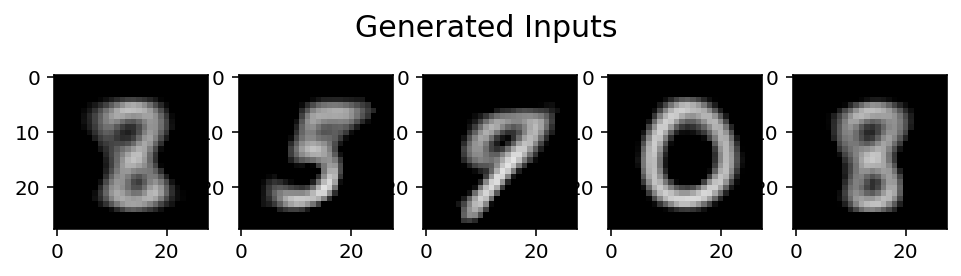

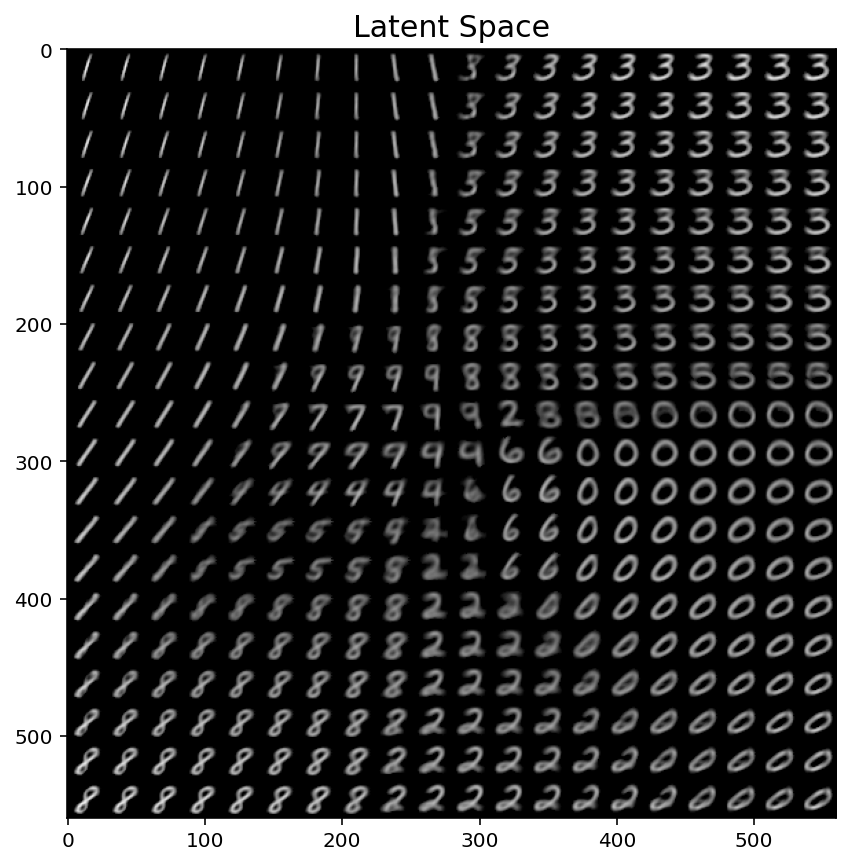

[41/50] recon:[0.253] kl:[0.038].
[42/50] recon:[0.254] kl:[0.038].
[43/50] recon:[0.252] kl:[0.039].
[44/50] recon:[0.252] kl:[0.039].
[45/50] recon:[0.253] kl:[0.039].
[46/50] recon:[0.252] kl:[0.039].
[47/50] recon:[0.252] kl:[0.039].
[48/50] recon:[0.251] kl:[0.039].
[49/50] recon:[0.251] kl:[0.039].


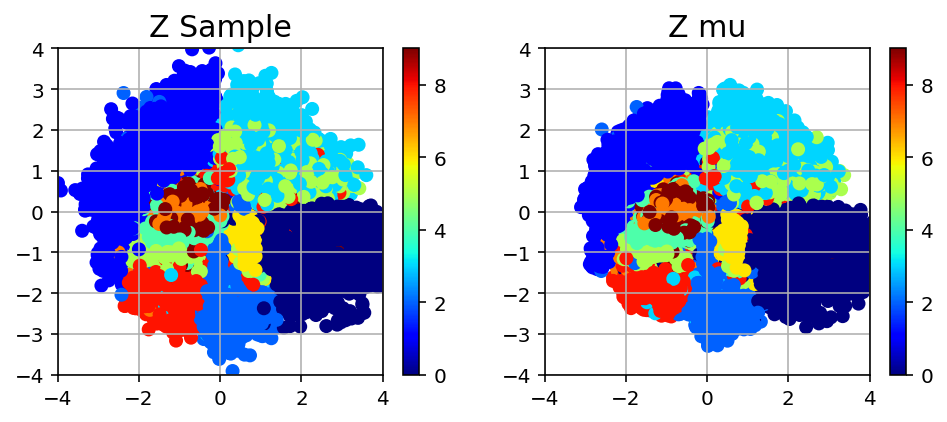

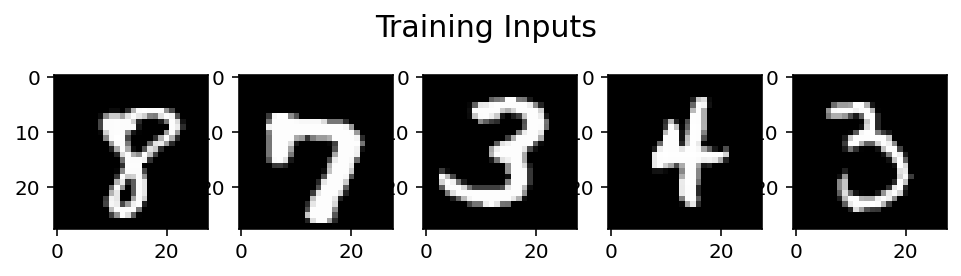

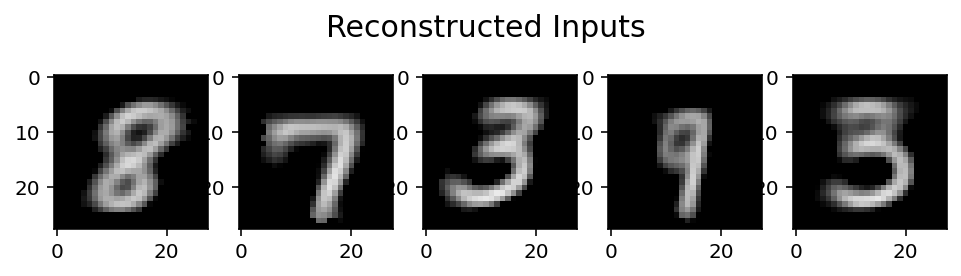

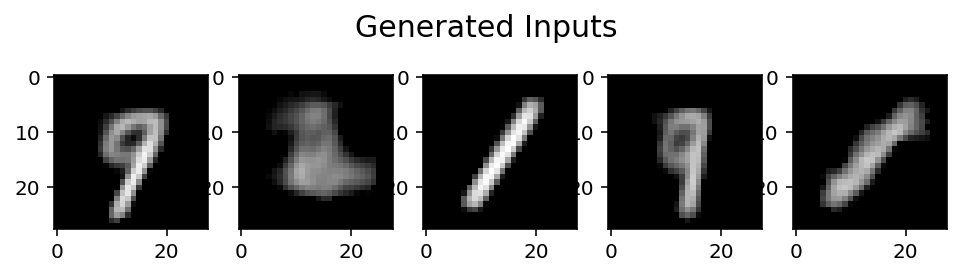

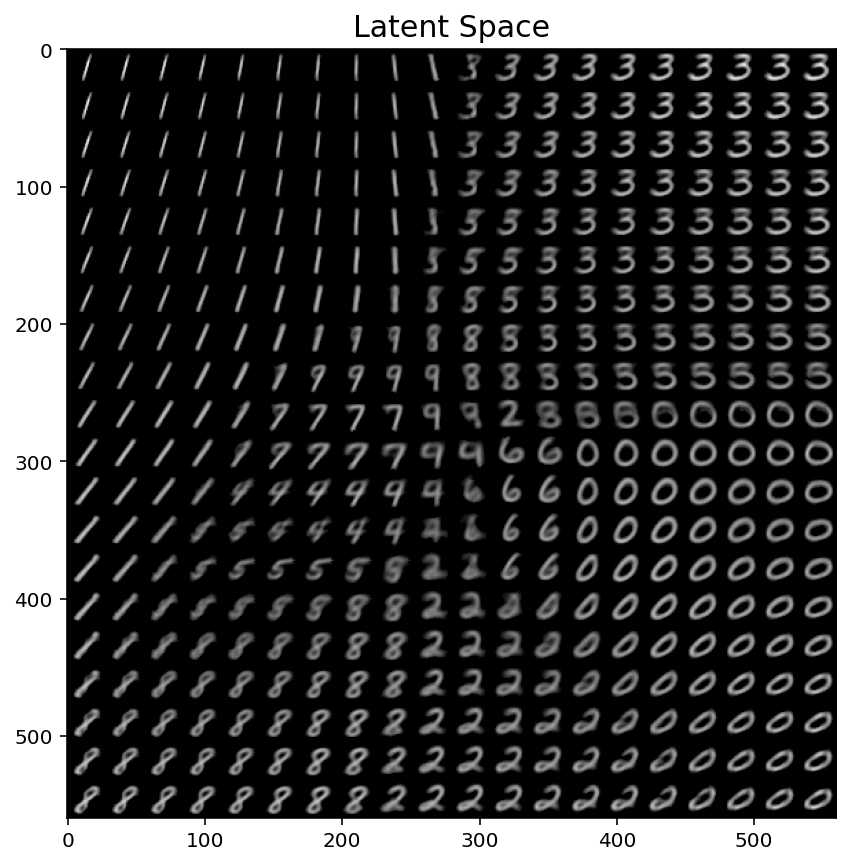

Done.


In [6]:
sess.run(tf.global_variables_initializer())
n_epoch,batch_size,print_every,plot_every = 50,128,1,10
for epoch in range(n_epoch):
    r_idx = np.random.permutation(n)
    # Update
    recon_loss_val_sum,kl_loss_val_sum = 0.0,0.0
    for it in range(n//batch_size):
        batch_idx = r_idx[it*batch_size:(it+1)*batch_size]
        x_batch = x[batch_idx,:]
        recon_loss_val,kl_loss_val = V.update(sess,x_batch=x_batch,lr=1e-3)
        recon_loss_val_sum += recon_loss_val
        kl_loss_val_sum += kl_loss_val
    recon_loss_val_avg,kl_loss_val_avg = recon_loss_val_sum/n,kl_loss_val_sum/n
    
    # Print
    if ((epoch%print_every)==0) or (epoch==(n_epoch-1)):
        print ("[%d/%d] recon:[%.3f] kl:[%.3f]."%
               (epoch,n_epoch,recon_loss_val_avg,kl_loss_val_avg))
    
    # Plot
    if ((epoch%plot_every)==0) or (epoch==(n_epoch-1)):
        # Plot z sample and z mu 
        plot_z_sample_and_mu(V,sess,x)

        # Plot input and reconstruction
        plot_input_and_reconstruction(V,sess,x)
        
        # Plot generated input
        plot_generated_input(V,sess,x)
        
        # Plot latent space
        plot_latent_space(V,sess,x)
        
print ("Done.")